In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import pandas as pd
import statsmodels.api as sm
import glob
import json
from pathlib import Path

In [23]:
import json
import os

# Load local config file
config_path = Path('config.json')
if not config_path.exists():
    raise FileNotFoundError("Missing config.json. Please create one with your local data path.")

with open(config_path, 'r') as f:
    config = json.load(f)

# Access the data path
datadir = Path(config['data_path'])

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

In [24]:
def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files

def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def extract_neuron_profile(file_path):
    """
    Extracts neuron tuning profiles from a single HDF5 session file.

    Parameters:
    - file_path: str, path to the .h5 file

    Returns:
    - neuron_profile: pd.DataFrame with tuning betas, p-values, and metadata
    """
    # Load firing rates and metadata
    fr_CdN = pull_from_h5(file_path, 'CdN_zFR')
    fr_OFC = pull_from_h5(file_path, 'OFC_zFR')
    firing_rates = np.concatenate([fr_CdN, fr_OFC], axis=2)

    u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'),
                              pull_from_h5(file_path, 'OFC_u_names')], axis=0)

    n_CdN = fr_CdN.shape[2]
    n_OFC = fr_OFC.shape[2]
    brain_areas = np.concatenate([np.zeros(n_CdN), np.ones(n_OFC)]).astype(int)

    u_locations = np.concatenate([pull_from_h5(file_path, 'CdN_locations'),
                                  pull_from_h5(file_path, 'OFC_locations')], axis=0)

    bhv = pd.read_hdf(file_path, key='bhv')
    if len(bhv) > len(firing_rates):
        bhv = bhv.iloc[:len(firing_rates)]

    # Trial selection
    trials2keep = bhv['n_sacc'] > 0
    bhv = bhv.loc[trials2keep]
    firing_rates = firing_rates[trials2keep, :, :]
    firing_rates = np.nan_to_num(firing_rates, nan=0)

    # Best-choice trials
    mask = (bhv['n_sacc'] == 1) & (bhv['picked_best'] == 1)
    trial_profile = bhv[mask].reset_index()
    firing_single_best = firing_rates[mask.values, :, :]

    mean_FR = firing_single_best.mean(axis=1)  # shape: (n_trials, n_units)
    n_units = mean_FR.shape[1]

    # GLM design matrix
    df = pd.DataFrame({
        'value': trial_profile['ch_val'].values,
        'state': trial_profile['state'].values
    })
    state_dummies = pd.get_dummies(df['state'].astype(int), prefix='state')
    df = pd.concat([df, state_dummies], axis=1)

    df['state_value_1'] = df['value'] * df['state_1']
    df['state_value_2'] = df['value'] * df['state_2']
    df['state_value_3'] = df['value'] * df['state_3']

    tuning_cols = ['value', 'state_1', 'state_2', 'state_3',
                   'state_value_1', 'state_value_2', 'state_value_3']
    X = df[tuning_cols].astype(int)
    X = sm.add_constant(X)

    # Fit GLM for each neuron
    beta_dict = {col: [] for col in X.columns}
    pval_dict = {col: [] for col in X.columns}

    for i in range(n_units):
        y = mean_FR[:, i]
        model = sm.OLS(y, X).fit()
        for col in X.columns:
            beta_dict[col].append(model.params[col])
            pval_dict[col].append(model.pvalues[col])

    # Assemble neuron profile
    neuron_profile = pd.DataFrame({
        'neuron': u_names,
        'brain_area': brain_areas,
        'lateral': u_locations[:, 0],
        'depth': u_locations[:, 1],
        **{f'{col}_beta': beta_dict[col] for col in X.columns},
        **{f'{col}_pval': pval_dict[col] for col in X.columns}
    })

    return neuron_profile

def plot_neuron_centric_density(neuron_profile, tarkget_neurons=1, reference_filter=1, step_size=50, win_size=50):
    """
    Plots neuron-centric density of value-coding neurons.

    Parameters:
    - neuron_profile (pd.DataFrame): DataFrame containing neuron profiles with 'coding_type', 'value_correlation', and 'depth' columns.
    - tarkget_neurons (int): Target neuron type to analyze (1 for positive, -1 for negative).
    - reference_filter (int): Reference neuron type to filter by (1 for positive, -1 for negative).
    """
    target_property = {1: 'Positive', -1: 'Negative'}[tarkget_neurons]
    reference_property = {1: 'Positive', -1: 'Negative'}[reference_filter]
    u2plot = (neuron_profile['coding_type'] != 'none') & (neuron_profile['value_correlation'] == reference_filter)
    u_betas = neuron_profile[u2plot]['value_correlation']
    u_depths = neuron_profile[u2plot]['depth']

    half_depth = (neuron_profile[u2plot]['depth'].max() - neuron_profile[u2plot]['depth'].min()) / 2
    distances = np.arange(-half_depth, half_depth + 1, step_size)

    all_u_centric_densities = []

    for u in range(len(u_betas)):
        center_depth = u_depths.iloc[u]

        # Precompute masks for each window
        window_masks = [(u_depths >= center_depth + d - win_size) & 
                        (u_depths < center_depth + d + win_size) 
                        for d in distances]
        window_masks = np.stack(window_masks)  # shape: (num_windows, num_neurons)

        tarkget_mask = (u_betas == tarkget_neurons).astype(float)  # shape: (num_neurons,)

        # Compute densities for each neuron by applying window masks
        # Resulting shape: (num_neurons, num_windows)
        u_counts = window_masks.sum(axis=1)
        u_centric_densities = (window_masks @ tarkget_mask) / np.maximum(u_counts, 1)  # avoid division by zero

        all_u_centric_densities.append(u_centric_densities)
        
    all_u_centric_densities = np.array(all_u_centric_densities)
    mean_density = all_u_centric_densities.mean(axis=0)

    # Plot the density curve
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=distances, y=mean_density, color='blue')
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
    plt.title(f'Fraction of {target_property} Neurons Relative to {reference_property} Neurons. Step {step_size}, Win {win_size}')
    plt.xlabel('Relative Depth (μm)')
    plt.ylabel(f'Fraction of {target_property} Neurons')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_coding_type(neuron_profile, p_thresh=0.05):
    """Classify neurons based on their coding type using p-value thresholds.
    
    Parameters:
    neuron_profile (pd.DataFrame): DataFrame containing neuron profiles with p-values.
    p_thresh (float): Significance threshold for p-values.
    Returns:
    
    pd.DataFrame: Updated DataFrame with a new 'coding_type' column.
    """
    
    # State coding: any state term is significant
    state_coding = (
        (neuron_profile['state_1_pval'] < p_thresh) |
        (neuron_profile['state_2_pval'] < p_thresh) |
        (neuron_profile['state_3_pval'] < p_thresh)
    )

    # Value coding: value term is significant, but not state coding
    val_coding = (neuron_profile['value_pval'] < p_thresh) & (~state_coding)

    # state_value coding: any interaction term is significant, but not pure value coding
    state_val_coding = (
        (neuron_profile['state_value_1_pval'] < p_thresh) |
        (neuron_profile['state_value_2_pval'] < p_thresh) |
        (neuron_profile['state_value_3_pval'] < p_thresh)
    ) & (~val_coding)

    # Refine state coding: exclude neurons already classified as state_val_coding
    state_coding = state_coding & (~state_val_coding)
    
    neuron_profile['coding_type'] = 'none'  # default
    neuron_profile.loc[state_coding, 'coding_type'] = 'state'
    neuron_profile.loc[val_coding, 'coding_type'] = 'value'
    neuron_profile.loc[state_val_coding, 'coding_type'] = 'state_value'
    
    return neuron_profile

def get_value_correlation(row):
    if row['coding_type'] == 'value':
        return np.sign(row['value_beta'])
    
    elif row['coding_type'] == 'state':
        state_betas = [row['state_1_beta'], row['state_2_beta'], row['state_3_beta']]
        max_idx = np.argmax(np.abs(state_betas))
        return np.sign(state_betas[max_idx])
    
    elif row['coding_type'] == 'state_value':
        val_state_betas = [row['state_value_1_beta'], row['state_value_2_beta'], row['state_value_3_beta']]
        max_idx = np.argmax(np.abs(val_state_betas))
        return np.sign(val_state_betas[max_idx])
    
    else:
        return 'none'


In [25]:
data_files = find_h5_files(datadir)
data_files 

['D:\\Projects\\rotation_project\\data2analyze\\D20231219_Rec05.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\D20231221_Rec06.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\D20231224_Rec07.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\D20231227_Rec08.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\K20240707_Rec06.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\K20240710_Rec07.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\K20240712_Rec08.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\K20240715_Rec09.h5']

In [26]:
file_path = 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231227_Rec08.h5'

In [27]:
neuron_profile = extract_neuron_profile(file_path)
neuron_profile = get_coding_type(neuron_profile, p_thresh=0.05)
neuron_profile['value_correlation'] = neuron_profile.apply(get_value_correlation, axis=1)

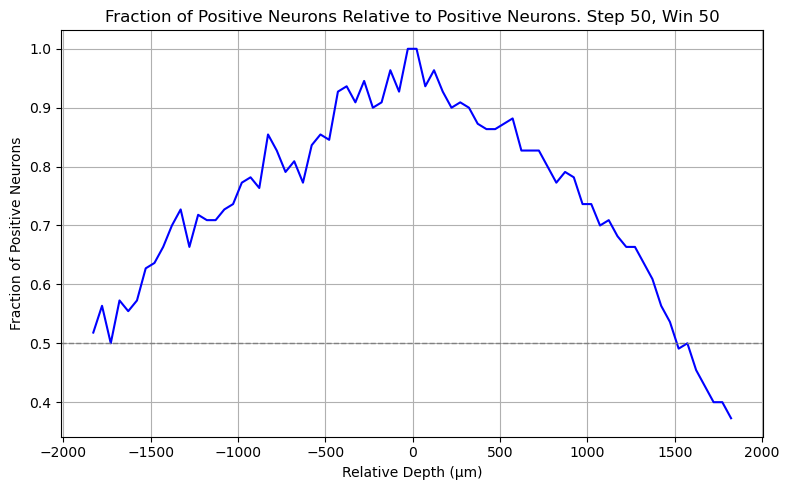

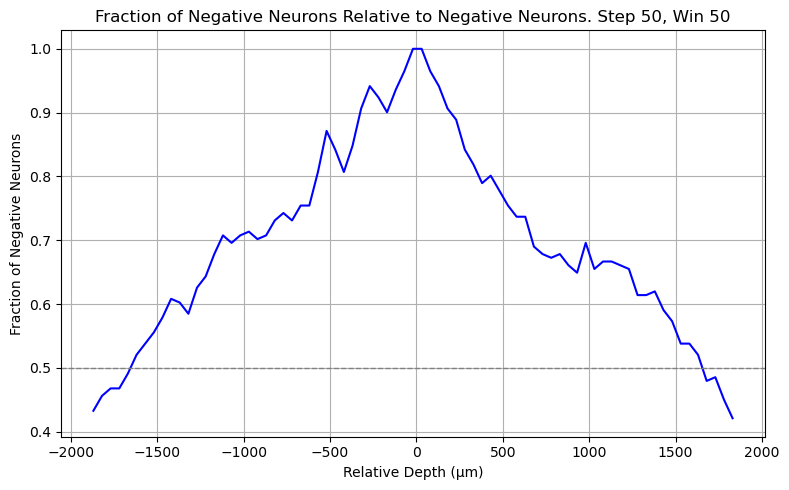

In [28]:
plot_neuron_centric_density(neuron_profile, tarkget_neurons=1, reference_filter=1, step_size=50, win_size=50)
plot_neuron_centric_density(neuron_profile, tarkget_neurons=-1, reference_filter=-1, step_size=50, win_size=50)

In [33]:
data_files = find_h5_files(datadir)

all_profiles = []
for file_path in data_files:
    profile = extract_neuron_profile(file_path)
    profile['session'] = file_path.split('\\')[-1].replace('.h5', '')
    all_profiles.append(profile)

all_neuron_profile = pd.concat(all_profiles, ignore_index=True)
all_neuron_profile = get_coding_type(all_neuron_profile, p_thresh=0.05)
all_neuron_profile['value_correlation'] = neuron_profile.apply(get_value_correlation, axis=1)

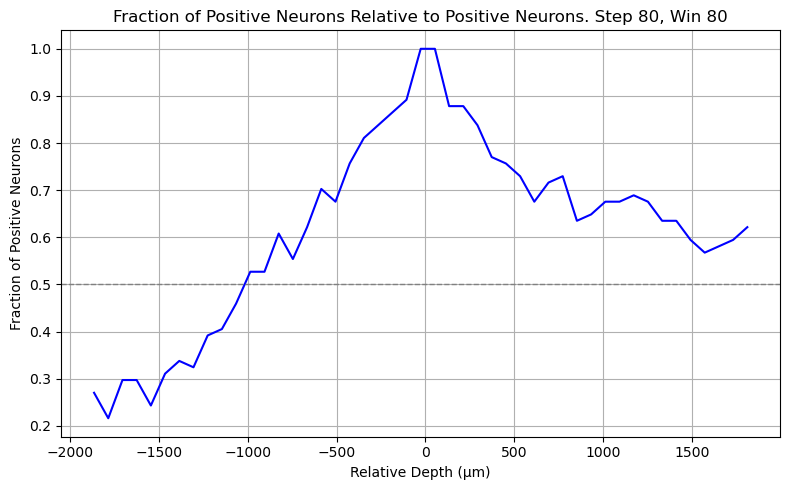

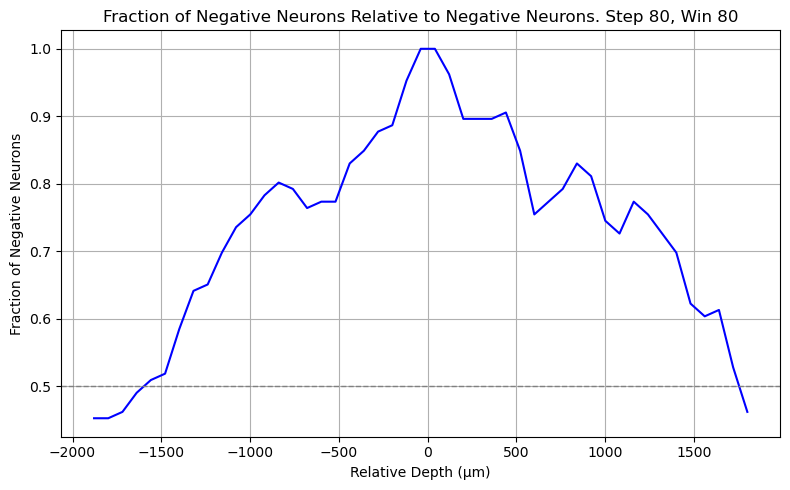

In [41]:
plot_neuron_centric_density(all_neuron_profile, tarkget_neurons=1, reference_filter=1, step_size=80, win_size=80)
plot_neuron_centric_density(all_neuron_profile, tarkget_neurons=-1, reference_filter=-1, step_size=80, win_size=80)